Nama : M. Iqbal Baskoro

# Data & Algoritma Understanding

## Data Understanding

### 📊 Nama Dataset
liputan6_data.tar.gz

### 🌍 Languages
- Indonesian

### 🧩 Data Structure
|Nama Kolom|Tipe Data|
|----|--------|
|`id`|`string`|
|`url`|`string`|
|`clean_article`|`string`|
|`clean_summary`|`string`|
|`extractive_summary`|`string`|

### ⚙️ Data Instances
|Nama Kolom|Contoh Data|
|----------|-----------|
|`id`|26408|
|`url`|https://www.liputan6.com/news/read/26408/pbb-siap-membantu-penyelesaian-konflik-ambon|
|`clean_article`|Liputan6.com, Ambon: Partai Bulan Bintang wilayah Maluku bertekad membantu pemerintah menyelesaikan konflik di provinsi tersebut. Syaratnya, penanganan penyelesaian konflik Maluku harus dimulai dari awal kerusuhan, yakni 19 Januari 1999. Demikian hasil Musyawarah Wilayah I PBB Maluku yang dimulai Sabtu pekan silam dan berakhir Senin (31/12) di Ambon. Menurut seorang fungsionaris PBB Ridwan Hasan, persoalan di Maluku bisa selesai asalkan pemerintah dan aparat keamanan serius menangani setiap persoalan di Maluku secara komprehensif dan bijaksana. Itulah sebabnya, PBB wilayah Maluku akan menjadikan penyelesaian konflik sebagai agenda utama partai. PBB Maluku juga akan mendukung penegakan hukum secara terpadu dan tanpa pandang bulu. Siapa saja yang melanggar hukum harus ditindak. Ridwan berharap, Ketua PBB Maluku yang baru, Ali Fauzi, dapat menindak lanjuti agenda politik partai yang telah diamanatkan dan mau mendukung penegakan hukum di Maluku. (ULF/Sahlan Heluth).|
|`clean_summary`|Konflik Ambon telah berlangsung selama tiga tahun. Partai Bulan Bintang wilayah Maluku siap membantu pemerintah menyelesaikan kasus di provinsi tersebut.|
|`extractive_summary`|Liputan6.com, Ambon: Partai Bulan Bintang wilayah Maluku bertekad membantu pemerintah menyelesaikan konflik di provinsi tersebut. Siapa saja yang melanggar hukum harus ditindak.|

### 📅 Data Fields
|Nama Kolom|Keterangan|
|----------|----------|
|`id`|Kolom id unique|
|`url`|URL Article|
|`clean_article`|Isi original article|
|`clean_summary`|Ringkasan Abstract|
|`extractive_summary`|Ringkasan Ekstractif|

## Algoritma Understanding

# Model Training & Evaluation

### 1. Load Dataset & Convert Data

In [3]:
import pandas as pd
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import json
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup 
from torch.optim import AdamW
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_recall_curve, f1_score, 
                            classification_report, confusion_matrix, roc_auc_score, roc_curve,
                            precision_score, recall_score)
import warnings
warnings.filterwarnings('ignore')

print("✅ Semua library yang dibutuhkan berhasil dimuat.")

✅ Semua library yang dibutuhkan berhasil dimuat.


### 2. Memuat dan Menyiapkan Data Awal

In [4]:
print("📖 Memuat data dari file-file JSON...")
file_list = glob.glob('../data/liputan6_data/canonical/train/*.json')
df_list = []
total_rows = 0
limit = 1000

for f in file_list:
    try:
        temp_df = pd.read_json(f, lines=True)
        df_list.append(temp_df)
        total_rows += len(temp_df)
        if total_rows >= limit:
            break 
    except ValueError:
        print(f"Peringatan: Melewatkan file {f} karena format JSON tidak valid atau kosong.")
        continue

df = pd.concat(df_list, ignore_index=True)
df = df.head(limit)
df.head()

📖 Memuat data dari file-file JSON...


,id,url,clean_article,clean_summary,extractive_summary
0,100000,https://www.liputan6.com/news/read/100000/yudh...,"[[Liputan6, ., com, ,, Jakarta, :, Presiden, S...","[[Menurut, Presiden, Susilo, Bambang, Yudhoyon...","[0, 1]"
1,100002,https://www.liputan6.com/news/read/100002/jepa...,"[[Liputan6, ., com, ,, Jakarta, :, Perdana, Me...","[[Pada, masa, silam, Jepang, terlalu, ambisius...","[2, 3]"
2,100003,https://www.liputan6.com/news/read/100003/pulu...,"[[Liputan6, ., com, ,, Kutai, :, Banjir, denga...","[[Puluhan, hektare, areal, persawahan, yang, s...","[1, 5]"
3,100004,https://www.liputan6.com/news/read/100004/pres...,"[[Liputan6, ., com, ,, Jakarta, :, Presiden, S...","[[Sekjen, PBB, Kofi, Annan, memuji, langkah, P...","[2, 5]"
4,100005,https://www.liputan6.com/news/read/100005/warg...,"[[Liputan6, ., com, ,, Solok, :, Warga, Kampun...","[[Untuk, mempercepat, pelaksanaan, belajar-men...","[0, 2]"


In [5]:
print(f"✅ Total data mentah yang berhasil dimuat: {len(df)} baris.")
print("\n📝 Memproses artikel menjadi dataset kalimat...")

all_sentences = []
all_labels = []

for _, row in df.iterrows():
    article_nested_sentences = row['clean_article']
    
    # Lewati jika artikel kosong
    if not isinstance(article_nested_sentences, list) or not article_nested_sentences:
        continue
        
    # Gabungkan token menjadi kalimat utuh
    article_sentences = [" ".join(sent) for sent in article_nested_sentences if sent]
    summary_indices = set(row['extractive_summary'])
    
    # Lewati jika tidak ada kalimat yang valid setelah diproses
    if not article_sentences:
        continue

    labels = [1 if i in summary_indices else 0 for i in range(len(article_sentences))]
    
    all_sentences.extend(article_sentences)
    all_labels.extend(labels)

print(f"✅ Proses selesai. Total kalimat: {len(all_sentences)}, Total label: {len(all_labels)}")

num_examples = min(5, len(all_sentences))
if num_examples > 0:
    print("\nContoh data yang telah diproses:")
    for i in range(num_examples):
        # Ambil 5 kalimat pertama dari dataset yang sudah diproses
        print(f"  - Kalimat: '{all_sentences[i][:70]}...' | Label: {all_labels[i]}")
else:
    print("\n🚨 Peringatan: Tidak ada kalimat yang berhasil diproses. Periksa struktur data JSON Anda.")

✅ Total data mentah yang berhasil dimuat: 1000 baris.

📝 Memproses artikel menjadi dataset kalimat...
✅ Proses selesai. Total kalimat: 13126, Total label: 13126

Contoh data yang telah diproses:
  - Kalimat: 'Liputan6 . com , Jakarta : Presiden Susilo Bambang Yudhoyono menekanka...' | Label: 1
  - Kalimat: 'Yudhoyono berharap masalah ini menjadi pembahasan penting dalam Konfer...' | Label: 1
  - Kalimat: 'Demikian pidato Yudhoyono saat membuka KTT Asia-Afrika di Jakarta Conv...' | Label: 0
  - Kalimat: 'Pada awal pidatonya , Yudhoyono para peserta untuk mengheningkan cipta...' | Label: 0
  - Kalimat: 'Selanjutnya , Yudhoyono menegaskan pertemuan ini bukanlah sekadar roma...' | Label: 0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   url                 1000 non-null   object
 2   clean_article       1000 non-null   object
 3   clean_summary       1000 non-null   object
 4   extractive_summary  1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


### 3. Membagi Data menjadi Training, Validasi, dan Test

In [7]:
# Bagi data menjadi training (80%) dan data sementara (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_sentences, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Bagi data sementara menjadi validasi (10%) dan test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("📦 Ukuran dataset setelah dibagi:")
print(f"   - Training Set  : {len(X_train)} sampel")
print(f"   - Validation Set: {len(X_val)} sampel")
print(f"   - Test Set      : {len(X_test)} sampel")

📦 Ukuran dataset setelah dibagi:
   - Training Set  : 10500 sampel
   - Validation Set: 1313 sampel
   - Test Set      : 1313 sampel


### Analisis Distribusi Kelas dan Menghitung Bobot

📈 Menganalisis distribusi kelas dan menghitung class weights...

Distribusi kelas di Training Set: 8684 (Kelas 0) vs 1816 (Kelas 1)
Bobot Kelas yang dihitung: Bobot Kelas 0 = 0.6046, Bobot Kelas 1 = 2.8910


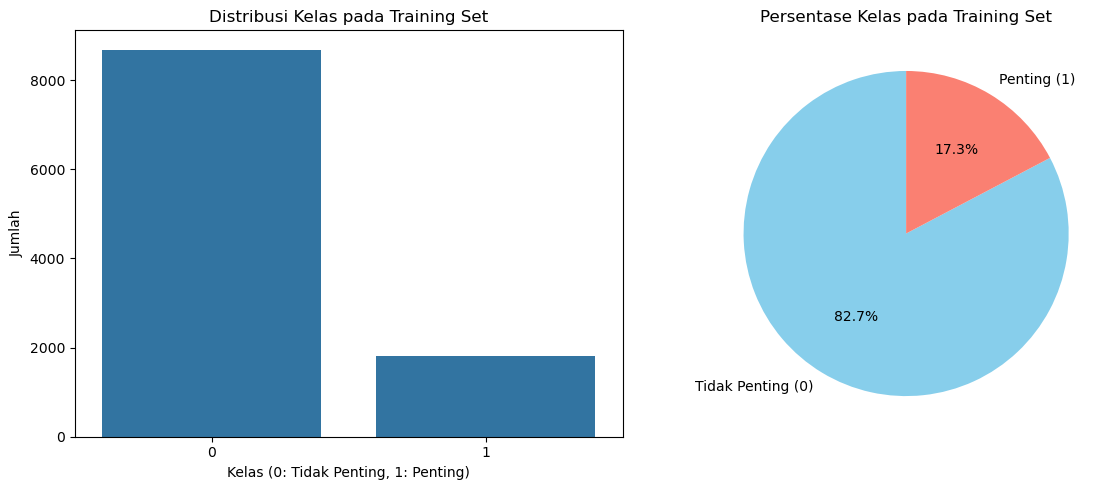

In [8]:
print("📈 Menganalisis distribusi kelas dan menghitung class weights...\n")
y_train_np, y_val_np, y_test_np = np.array(y_train), np.array(y_val), np.array(y_test)

# Hitung distribusi
train_counts = np.bincount(y_train_np)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)

print(f"Distribusi kelas di Training Set: {train_counts[0]} (Kelas 0) vs {train_counts[1]} (Kelas 1)")
print(f"Bobot Kelas yang dihitung: Bobot Kelas 0 = {class_weights[0]:.4f}, Bobot Kelas 1 = {class_weights[1]:.4f}")

# Visualisasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_np)
plt.title('Distribusi Kelas pada Training Set')
plt.xlabel('Kelas (0: Tidak Penting, 1: Penting)')
plt.ylabel('Jumlah')

plt.subplot(1, 2, 2)
plt.pie(train_counts, labels=['Tidak Penting (0)', 'Penting (1)'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Persentase Kelas pada Training Set')
plt.tight_layout()
plt.show()

# Konversi bobot ke tensor PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

### Setup Model dan Tokenizer BERT

In [9]:
MODEL_NAME = 'indobenchmark/indobert-base-p1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🖥️ Menggunakan device: {device.type.upper()}")

print(f"\n📝 Memuat tokenizer: {MODEL_NAME}...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

print(f"🤖 Memuat model: {MODEL_NAME}...")
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2,
    output_attentions=False, 
    output_hidden_states=False
)
model.to(device)

print(f"\n✅ Model dan tokenizer siap digunakan.")

🖥️ Menggunakan device: CUDA

📝 Memuat tokenizer: indobenchmark/indobert-base-p1...
🤖 Memuat model: indobenchmark/indobert-base-p1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ Model dan tokenizer siap digunakan.


### Tokenisasi Data dan Membuat DataLoaders

In [10]:
MAX_LENGTH = 128
BATCH_SIZE = 32

def create_dataset(tokenizer, sentences, labels):
    input_ids, attention_masks = [], []
    for sent in sentences:
        encoded = tokenizer.encode_plus(
            sent, add_special_tokens=True, max_length=MAX_LENGTH,
            padding='max_length', truncation=True, return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return TensorDataset(torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels))

print("📋 Mentokenisasi data...")
train_dataset = create_dataset(tokenizer, X_train, y_train)
val_dataset = create_dataset(tokenizer, X_val, y_val)
test_dataset = create_dataset(tokenizer, X_test, y_test)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

print("✅ DataLoaders berhasil dibuat.")
print(f"   - Training batches: {len(train_dataloader)}")
print(f"   - Validation batches: {len(val_dataloader)}")
print(f"   - Test batches: {len(test_dataloader)}")

📋 Mentokenisasi data...
✅ DataLoaders berhasil dibuat.
   - Training batches: 329
   - Validation batches: 42
   - Test batches: 42


### Menyiapkan Proses Training

In [11]:
EPOCHS = 3
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Pindahkan bobot kelas ke device yang sama dengan model
class_weights_tensor = class_weights_tensor.to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

print("🎛️ Konfigurasi Training:")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Learning Rate: {LEARNING_RATE}")
print(f"   - Total Training Steps: {total_steps}")
print(f"   - Loss Function: CrossEntropyLoss dengan bobot kelas")

🎛️ Konfigurasi Training:
   - Epochs: 3
   - Learning Rate: 2e-05
   - Total Training Steps: 987
   - Loss Function: CrossEntropyLoss dengan bobot kelas


### Training dan Validasi Model

In [12]:
training_history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*20} EPOCH {epoch + 1}/{EPOCHS} {'='*20}")
    
    # Training
    model.train()
    total_train_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = criterion(outputs.logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        if step % 50 == 0 and step > 0:
            print(f"  Batch {step}/{len(train_dataloader)}. Loss: {loss.item():.4f}")
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_history['train_loss'].append(avg_train_loss)
    print(f"\n  Average training loss: {avg_train_loss:.4f}")

    # Validasi 
    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = criterion(outputs.logits, b_labels)
            total_val_loss += loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    training_history['val_loss'].append(avg_val_loss)
    training_history['val_acc'].append(val_acc)
    training_history['val_f1'].append(val_f1)
    
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Validation F1-Score: {val_f1:.4f}")
    print("\n  Laporan Klasifikasi Validasi:")
    print(classification_report(all_labels, all_preds, target_names=['Tidak Penting', 'Penting']))

print("\n✅ Training selesai.")


==================== EPOCH 1/3 ====================
  Batch 50/329. Loss: 0.7992
  Batch 100/329. Loss: 0.6145
  Batch 150/329. Loss: 0.7847
  Batch 200/329. Loss: 0.5474
  Batch 250/329. Loss: 0.5743
  Batch 300/329. Loss: 0.5796

  Average training loss: 0.6578
  Validation Loss: 0.6563
  Validation Accuracy: 0.6992
  Validation F1-Score: 0.7275

  Laporan Klasifikasi Validasi:
               precision    recall  f1-score   support

Tidak Penting       0.88      0.74      0.80      1086
      Penting       0.29      0.51      0.37       227

     accuracy                           0.70      1313
    macro avg       0.58      0.62      0.59      1313
 weighted avg       0.78      0.70      0.73      1313


==================== EPOCH 2/3 ====================
  Batch 50/329. Loss: 0.5430
  Batch 100/329. Loss: 0.5063
  Batch 150/329. Loss: 0.6312
  Batch 200/329. Loss: 0.6746
  Batch 250/329. Loss: 0.5748
  Batch 300/329. Loss: 0.6327

  Average training loss: 0.5840
  Validation Loss:

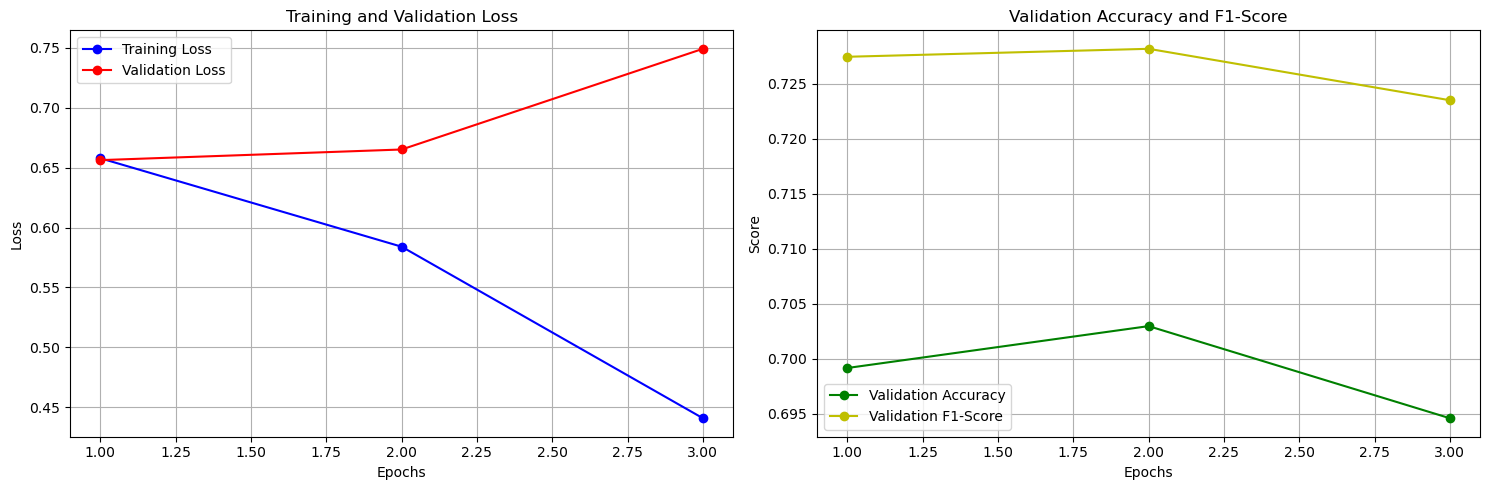

In [13]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_history['train_loss'], 'bo-', label='Training Loss')
plt.plot(epochs_range, training_history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_history['val_acc'], 'go-', label='Validation Accuracy')
plt.plot(epochs_range, training_history['val_f1'], 'yo-', label='Validation F1-Score')
plt.title('Validation Accuracy and F1-Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Mencari Threshold Optimal

🎯 Mencari threshold optimal pada data validasi...

✅ Threshold optimal ditemukan: 0.2577 (dengan F1-Score: 0.3862)


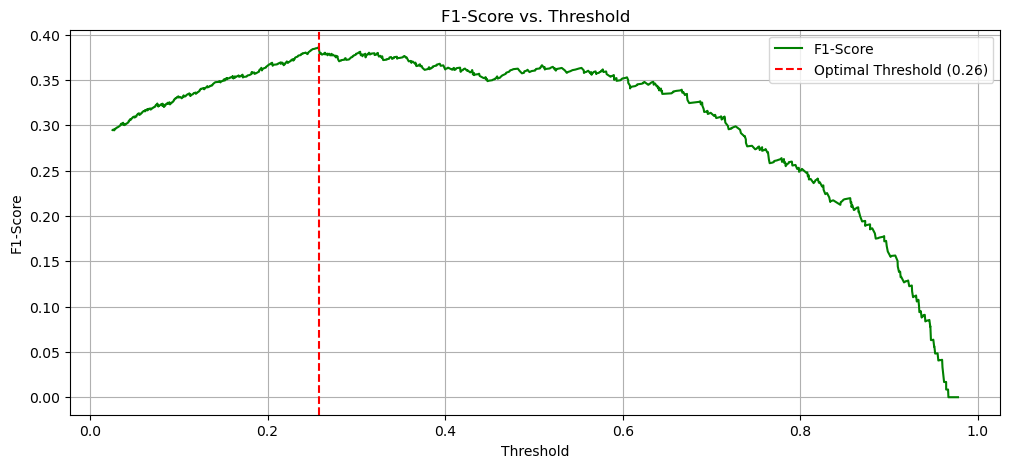

In [14]:
print("🎯 Mencari threshold optimal pada data validasi...")
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for batch in val_dataloader:
        _, _, b_labels = [b.to(device) for b in batch]
        outputs = model(batch[0].to(device), attention_mask=batch[1].to(device))
        probs = torch.softmax(outputs.logits, dim=1)[:, 1] # Probabilitas kelas positif
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\n✅ Threshold optimal ditemukan: {optimal_threshold:.4f} (dengan F1-Score: {f1_scores[optimal_idx]:.4f})")

# Buat Plotnya
plt.figure(figsize=(12, 5))
plt.plot(thresholds, f1_scores[:-1], 'g-', label='F1-Score')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.title('F1-Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

### Menyimpan Model dan Melakukan Prediksi

In [15]:
# Instal NLTK 
try:
    import nltk
except ImportError:
    print("Menginstal NLTK...")
    !pip install nltk
    import nltk

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Mengunduh model 'punkt' NLTK...")
    nltk.download('punkt')

from nltk.tokenize import sent_tokenize

print("\n✅ NLTK siap digunakan untuk tokenisasi kalimat.")


✅ NLTK siap digunakan untuk tokenisasi kalimat.


📊 Mengevaluasi model pada data validasi untuk mendapatkan probabilitas...
✅ Selesai mendapatkan probabilitas.
✅ Selesai menghitung metrik untuk setiap threshold.


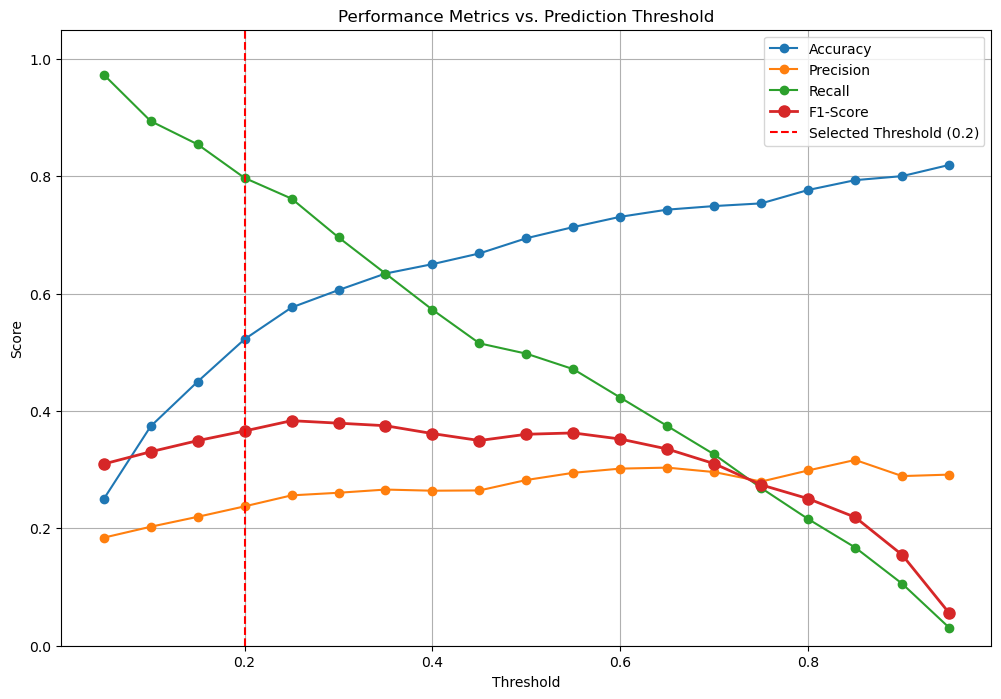

In [ ]:
print("📊 Mengevaluasi model pada data validasi untuk mendapatkan probabilitas...")

model.eval()
all_probs = []
all_true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        # Pindahkan batch ke device
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2]
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        
        # Ambil probabilitas untuk kelas "Penting" (kelas 1)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        
        all_probs.extend(probs.cpu().numpy())
        all_true_labels.extend(b_labels.numpy())

print("✅ Selesai mendapatkan probabilitas.")

# Hitung metrik untuk berbagai nilai threshold
thresholds = np.arange(0.05, 0.96, 0.05) 
accuracies = []
precisions = []
recalls = []
f1_scores = []

for thresh in thresholds:
    # Buat prediksi biner 
    preds = (np.array(all_probs) >= thresh).astype(int)
    
    # Hitung metrik dan simpan
    accuracies.append(accuracy_score(all_true_labels, preds))
    precisions.append(precision_score(all_true_labels, preds, zero_division=0))
    recalls.append(recall_score(all_true_labels, preds, zero_division=0))
    f1_scores.append(f1_score(all_true_labels, preds, zero_division=0))

print("✅ Selesai menghitung metrik untuk setiap threshold.")

plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracies, 'o-', label='Accuracy')
plt.plot(thresholds, precisions, 'o-', label='Precision')
plt.plot(thresholds, recalls, 'o-', label='Recall')
plt.plot(thresholds, f1_scores, 'o-', label='F1-Score', linewidth=2, markersize=8)

# Tandai threshold
optimal_threshold_to_show = 0.2
plt.axvline(x=optimal_threshold_to_show, color='r', linestyle='--', 
            label=f'Selected Threshold ({optimal_threshold_to_show})')

plt.title('Performance Metrics vs. Prediction Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05) # Batas sumbu y dari 0 sampai 1.05
plt.show()

In [16]:
SAVE_PATH = '../model/indobert-base-p1_epoch3_bs32'
os.makedirs(SAVE_PATH, exist_ok=True)

print(f"💾 Menyimpan model dan tokenizer ke direktori: {SAVE_PATH}")
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

# Konversi tipe data numpy.float32 ke float standar Python
# optimal_threshold_python_float = float(optimal_threshold) ============================================================
optimal_threshold_python_float = 0.2

config = {'optimal_threshold': optimal_threshold_python_float, 'model_name': MODEL_NAME}
with open(os.path.join(SAVE_PATH, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

print("✅ Model berhasil disimpan.")

# Fungsi Prediksi
def predict_sentence(text, model, tokenizer, device, threshold):
    model.eval()
    encoded = tokenizer.encode_plus(
        text, add_special_tokens=True, max_length=128,
        padding='max_length', truncation=True, return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prob = torch.softmax(outputs.logits, dim=1)[0, 1].item()
    
    prediction = "Penting" if prob >= threshold else "Tidak Penting"
    return prediction, prob

# Fungsi Buat Ringkasan
# Memecah teks menjadi kalimat dengan nltk
def summarize_text(long_text, model, tokenizer, device, threshold):
    sentences = sent_tokenize(long_text)
    
    important_sentences = []
    print("\n🔎 Menganalisis setiap kalimat (menggunakan NLTK):")
    for sentence in sentences:
        prediction, probability = predict_sentence(sentence, model, tokenizer, device, threshold)
        print(f"  - Prediksi: {prediction} (Prob: {probability:.2f}) | Kalimat: '{sentence[:50]}...'")
        if prediction == "Penting":
            important_sentences.append(sentence)
            
    # Gabungkan kalimat-kalimat penting menjadi satu ringkasan
    summary = " ".join(important_sentences)
    return summary

print("\n🔮 Membuat ringkasan dari teks baru...")

artikel_contoh = "Jakarta - Contoh-contoh teks artikel dapat dengan mudah ditemui terutama di media-media massa. Teks artikel adalah tulisan lengkap yang memiliki struktur judul, pendahuluan, penyajian masalah, pembahasan, dan penutup yang dimuat dalam surat kabar atau majalah. Berbeda dengan berita dan feature, teks artikel tidak mengaitkan isi tulisan dengan sumber berita sehingga informasi dalam teks artikel tidak akan basi. Berdasarkan buku Teknik Penulisan Berita, Feature, dan Artikel karya Prof. Drs. M. Atar Semi, teks artikel terdiri dari dua jenis, yaitu artikel ilmiah dan non-ilmiah, lho."

# Gunakan fungsi summarize_text 
ringkasan_hasil = summarize_text(artikel_contoh, model, tokenizer, device, optimal_threshold_python_float)

print("\n--- HASIL ---")
print("\n📝 Teks Asli:")
print(artikel_contoh)
print("\n✨ Ringkasan yang Dihasilkan:")
print(ringkasan_hasil)

💾 Menyimpan model dan tokenizer ke direktori: ../model/indobert-base-p1_epoch3_bs32
✅ Model berhasil disimpan.

🔮 Membuat ringkasan dari teks baru...

🔎 Menganalisis setiap kalimat (menggunakan NLTK):
  - Prediksi: Tidak Penting (Prob: 0.14) | Kalimat: 'Jakarta - Contoh-contoh teks artikel dapat dengan ...'
  - Prediksi: Penting (Prob: 0.22) | Kalimat: 'Teks artikel adalah tulisan lengkap yang memiliki ...'
  - Prediksi: Tidak Penting (Prob: 0.13) | Kalimat: 'Berbeda dengan berita dan feature, teks artikel ti...'
  - Prediksi: Tidak Penting (Prob: 0.14) | Kalimat: 'Berdasarkan buku Teknik Penulisan Berita, Feature,...'
  - Prediksi: Penting (Prob: 0.24) | Kalimat: 'M. Atar Semi, teks artikel terdiri dari dua jenis,...'

--- HASIL ---

📝 Teks Asli:
Jakarta - Contoh-contoh teks artikel dapat dengan mudah ditemui terutama di media-media massa. Teks artikel adalah tulisan lengkap yang memiliki struktur judul, pendahuluan, penyajian masalah, pembahasan, dan penutup yang dimuat dalam surat k